
==================== Checking Layer: ENC1 (30x30) ====================
MSE: 0.000008 | Max Err: 0.002930 | Status: ✅ PASS


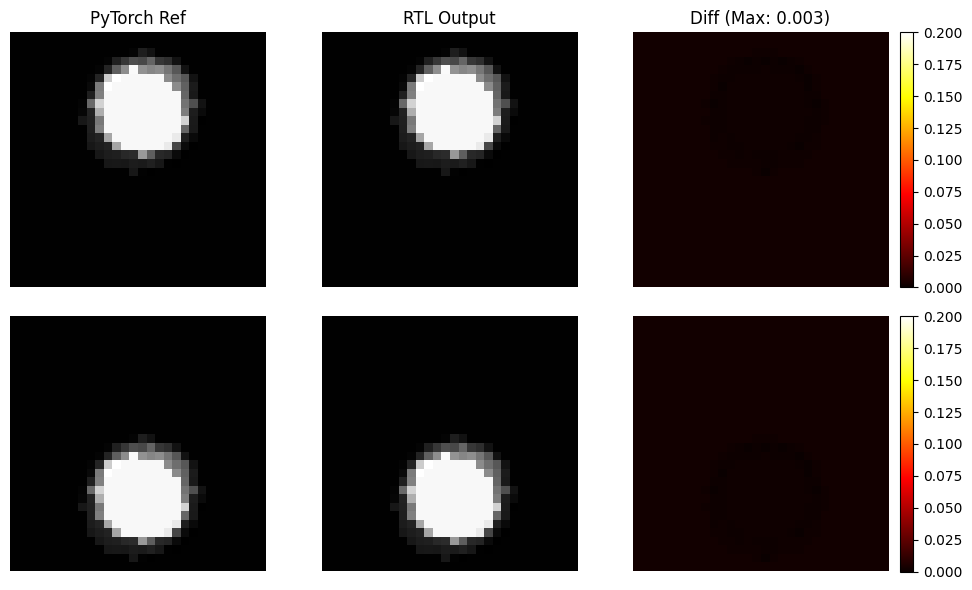


==================== Checking Layer: ENC2 (14x14) ====================
MSE: 0.000023 | Max Err: 0.009766 | Status: ✅ PASS


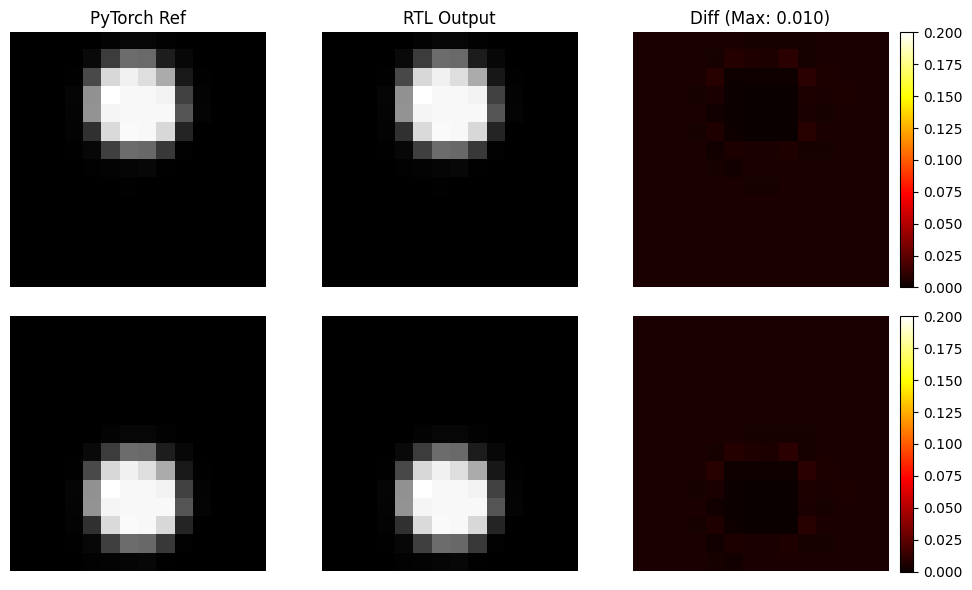


==================== Checking Layer: ENC3 (6x6) ====================
MSE: 0.000126 | Max Err: 0.024414 | Status: ✅ PASS


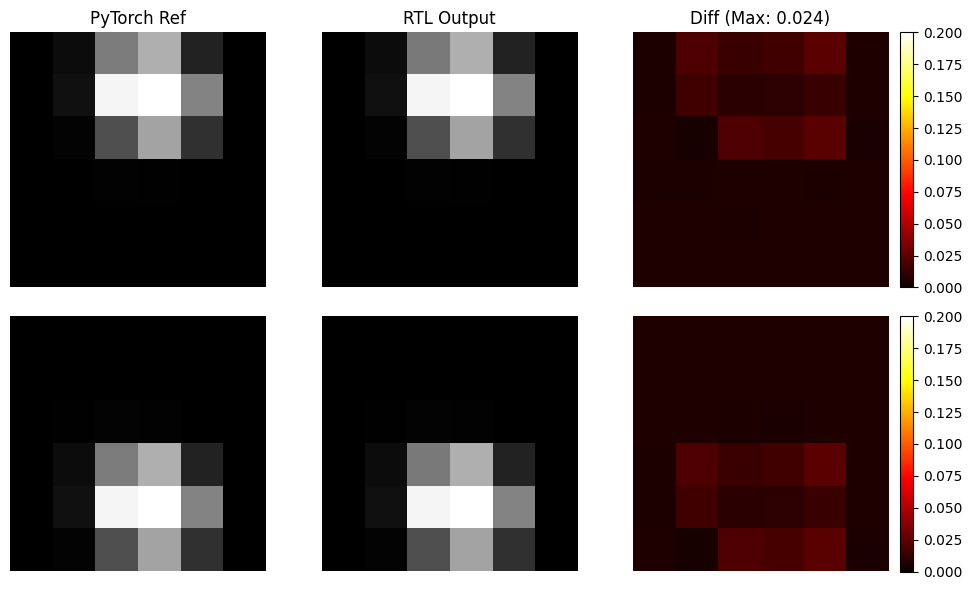


==================== Checking Layer: DEC1 (14x14) ====================
MSE: 0.000012 | Max Err: 0.010742 | Status: ✅ PASS


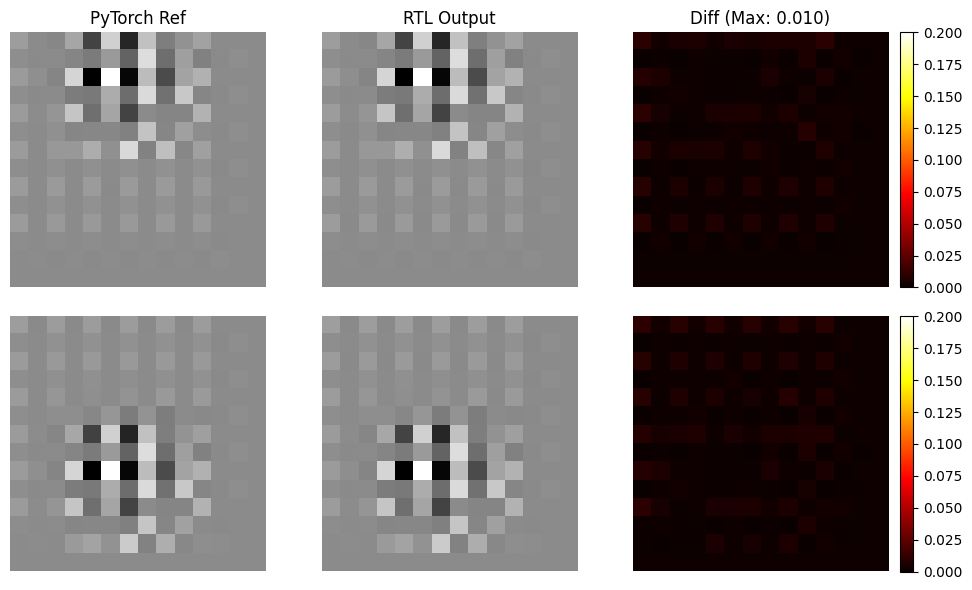


==================== Checking Layer: DEC2 (30x30) ====================
MSE: 0.000006 | Max Err: 0.013672 | Status: ✅ PASS


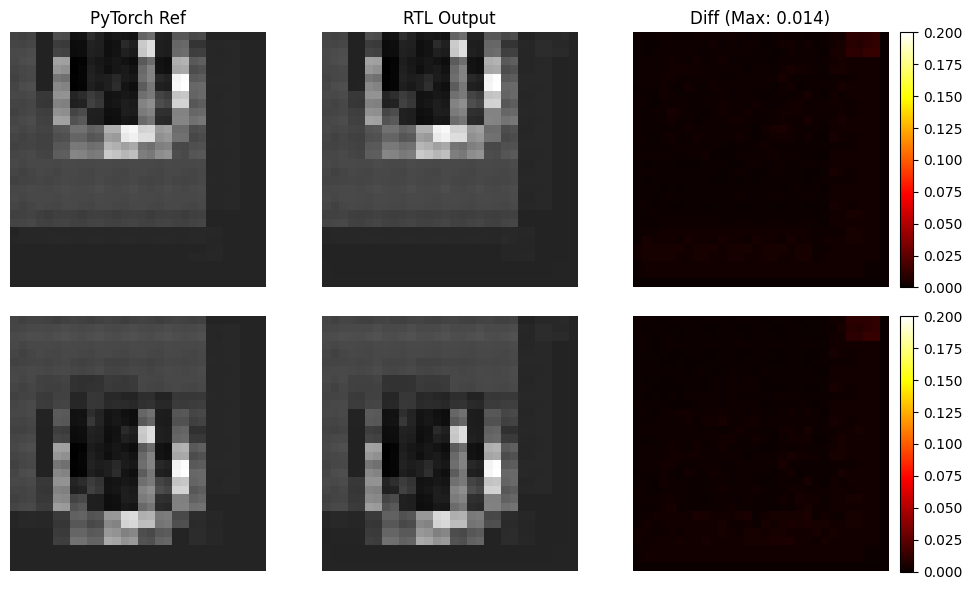


==================== Checking Layer: OUT (28x28) ====================
MSE: 0.000099 | Max Err: 0.016602 | Status: ✅ PASS


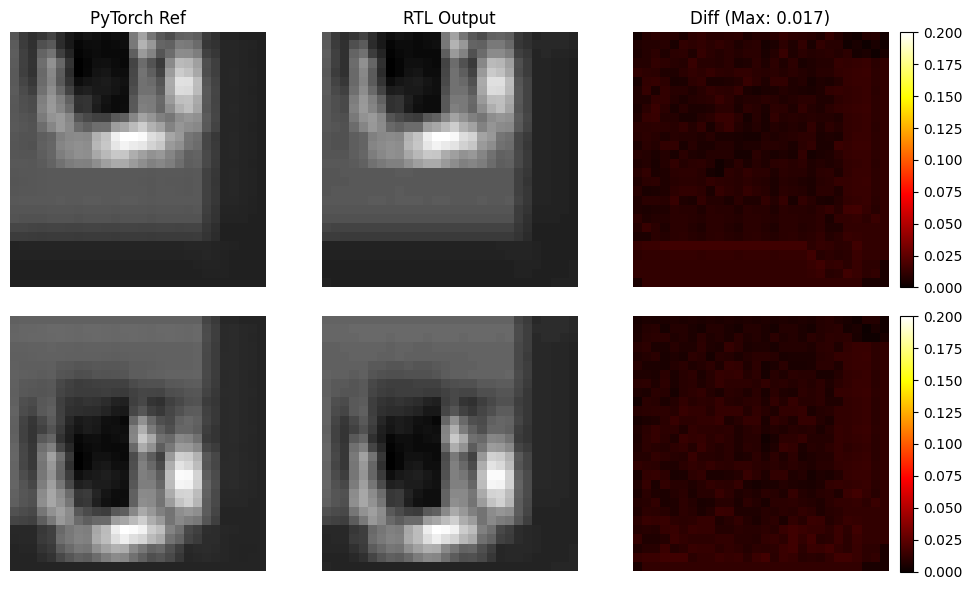

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- CONFIG ---
SCALE = 1024.0
DATA_DIR = "../data/tests/test1"
NUM_FRAMES = 2

# Definisi Layer: (Nama, Lebar, Tinggi)
LAYERS = [
    ("enc1", 30, 30),
    ("enc2", 14, 14),
    ("enc3",  6,  6),
    ("dec1", 14, 14),
    ("dec2", 30, 30),
    ("out",  28, 28)
]

def load_data(filename, h, w):
    path = os.path.join(DATA_DIR, filename)
    if not os.path.exists(path):
        print(f"❌ Missing: {filename}")
        return np.zeros((NUM_FRAMES, h, w))
    
    data = np.loadtxt(path, dtype=int)
    expected = NUM_FRAMES * h * w
    
    # Robustness handling
    if len(data) < expected:
        print(f"⚠️ {filename}: Data kurang ({len(data)}/{expected}). Padding with 0.")
        data = np.pad(data, (0, expected - len(data)))
    elif len(data) > expected:
        data = data[:expected]
        
    return data.reshape(NUM_FRAMES, h, w) / SCALE

# --- MAIN LOOP ---
for name, h, w in LAYERS:
    print(f"\n{'='*20} Checking Layer: {name.upper()} ({h}x{w}) {'='*20}")
    
    # Load Ref & RTL
    ref = load_data(f"ref_{name}.csv", h, w)
    rtl = load_data(f"rtl_{name}.csv", h, w)
    
    # Calc Error
    diff = np.abs(ref - rtl)
    mse = np.mean(diff**2)
    max_err = np.max(diff)
    
    status = "✅ PASS" if max_err < 0.1 else "❌ FAIL"
    print(f"MSE: {mse:.6f} | Max Err: {max_err:.6f} | Status: {status}")
    
    # Plotting
    fig, axes = plt.subplots(NUM_FRAMES, 3, figsize=(10, 3 * NUM_FRAMES))
    if NUM_FRAMES == 1: axes = np.expand_dims(axes, 0)
    
    for i in range(NUM_FRAMES):
        # Ref
        ax = axes[i][0]
        ax.imshow(ref[i], cmap='gray')
        if i==0: ax.set_title("PyTorch Ref")
        ax.axis('off')
        
        # RTL
        ax = axes[i][1]
        ax.imshow(rtl[i], cmap='gray')
        if i==0: ax.set_title("RTL Output")
        ax.axis('off')
        
        # Diff
        ax = axes[i][2]
        im = ax.imshow(diff[i], cmap='hot', vmin=0, vmax=0.2)
        if i==0: ax.set_title(f"Diff (Max: {np.max(diff[i]):.3f})")
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_279533/2219786647.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])


FileNotFoundError: [Errno 2] No such file or directory: '/home/gswt/gswt/BeGANnersLuck-FI-GAN/FIGAN/final/python/simulation/layer_verification_summary.png'

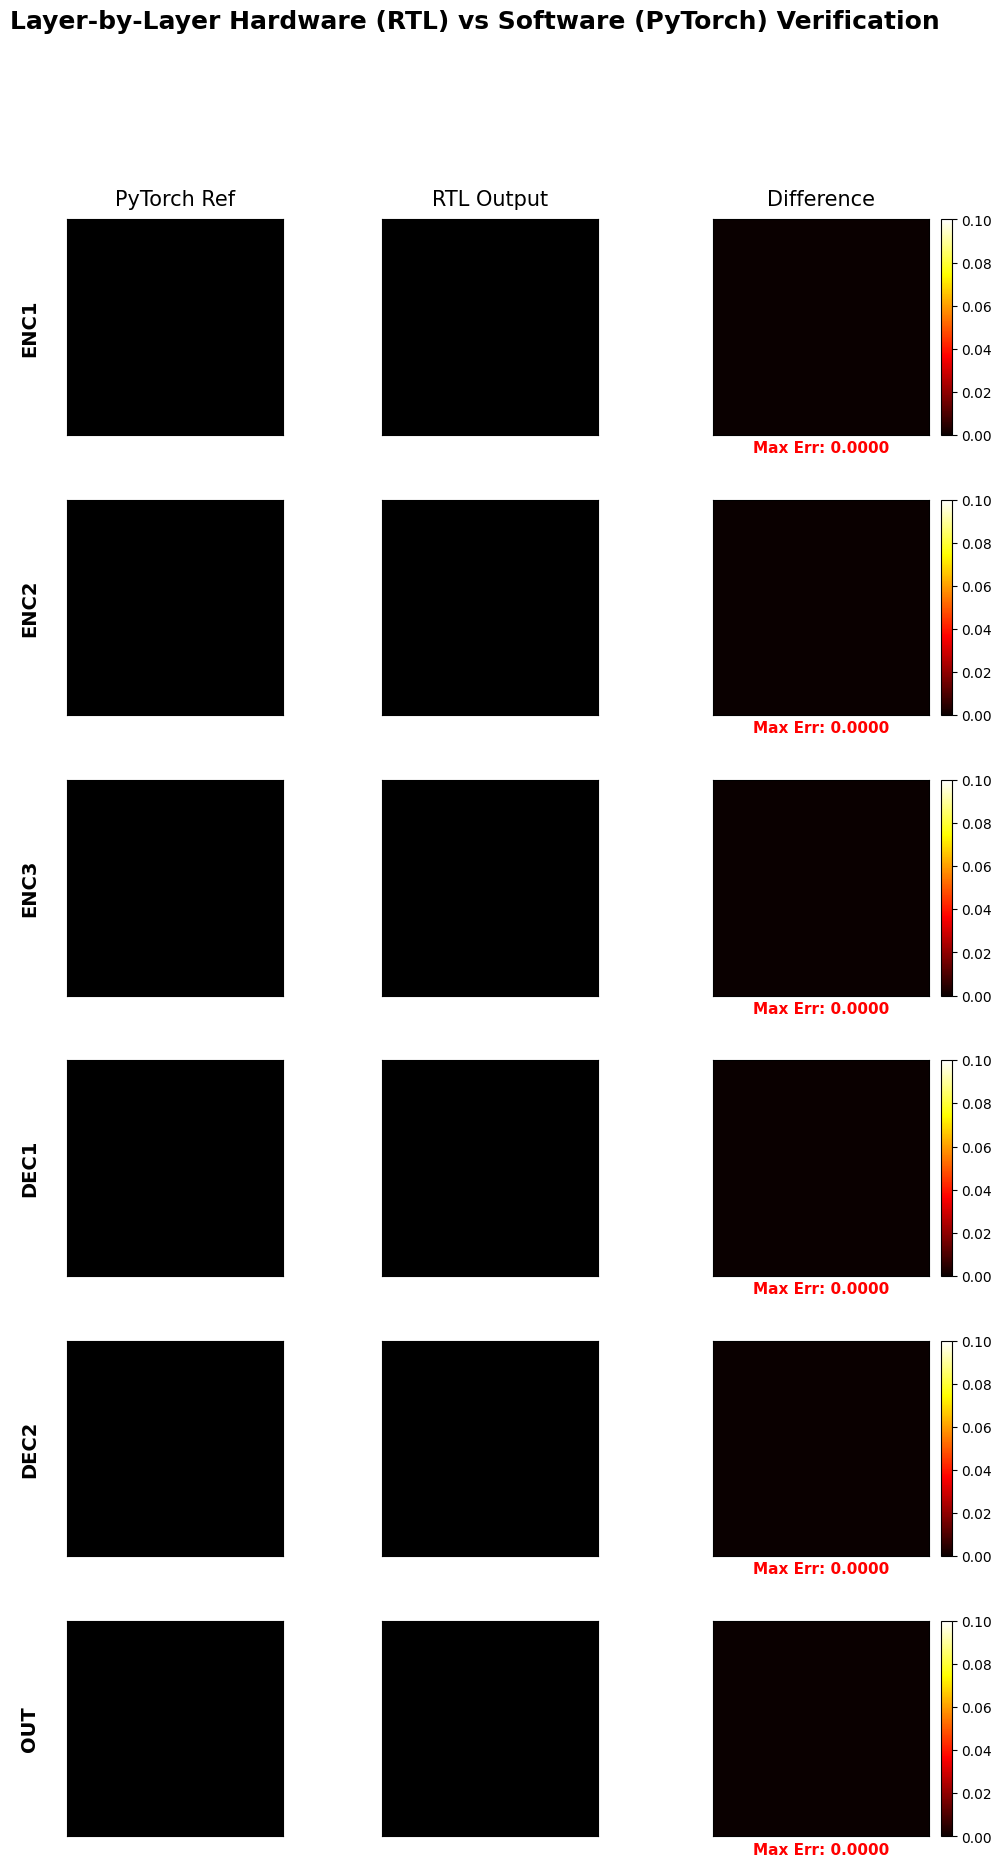

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- CONFIG ---
SCALE = 1024.0
DATA_DIR = "../data/tests/test1"
NUM_FRAMES = 2

# Definisi Layer: (Nama, Lebar, Tinggi)
LAYERS = [
    ("enc1", 30, 30),
    ("enc2", 14, 14),
    ("enc3",  6,  6),
    ("dec1", 14, 14),
    ("dec2", 30, 30),
    ("out",  28, 28)
]

def load_data(filename, h, w):
    path = os.path.join(DATA_DIR, filename)
    if not os.path.exists(path):
        print(f"❌ Missing: {filename}")
        return np.zeros((NUM_FRAMES, h, w))
    
    data = np.loadtxt(path, dtype=int)
    expected = NUM_FRAMES * h * w
    
    if len(data) < expected:
        print(f"⚠️ {filename}: Data kurang ({len(data)}/{expected}). Padding with 0.")
        data = np.pad(data, (0, expected - len(data)))
    elif len(data) > expected:
        data = data[:expected]
        
    return data.reshape(NUM_FRAMES, h, w) / SCALE

# --- MODIFIKASI: BUAT 1 FIGURE BESAR ---
total_layers = len(LAYERS)
total_rows = total_layers * NUM_FRAMES
# Buat grid besar: baris = (jumlah layer * frame), kolom = 3
fig, axes = plt.subplots(total_rows, 3, figsize=(12, 3 * total_rows))

# --- MAIN LOOP ---
for layer_idx, (name, h, w) in enumerate(LAYERS):
    print(f"\n{'='*20} Checking Layer: {name.upper()} ({h}x{w}) {'='*20}")
    
    ref = load_data(f"ref_{name}.csv", h, w)
    rtl = load_data(f"rtl_{name}.csv", h, w)
    
    diff = np.abs(ref - rtl)
    mse = np.mean(diff**2)
    max_err = np.max(diff)
    
    status = "✅ PASS" if max_err < 0.1 else "❌ FAIL"
    print(f"MSE: {mse:.6f} | Max Err: {max_err:.6f} | Status: {status}")
    
    for f_idx in range(NUM_FRAMES):
        # Hitung indeks baris global di grid besar
        row = (layer_idx * NUM_FRAMES) + f_idx
        
        # Ref
        ax = axes[row][0]
        ax.imshow(ref[f_idx], cmap='gray')
        ax.set_ylabel(f"{name.upper()}\nF{f_idx}", fontsize=10) # Label di pinggir kiri
        if row == 0: ax.set_title("PyTorch Ref")
        ax.axis('on') # 'on' supaya ylabel kelihatan
        ax.set_xticks([]); ax.set_yticks([]) # Hapus angka koordinat saja
        
        # RTL
        ax = axes[row][1]
        ax.imshow(rtl[f_idx], cmap='gray')
        if row == 0: ax.set_title("RTL Output")
        ax.axis('off')
        
        # Diff
        ax = axes[row][2]
        im = ax.imshow(diff[f_idx], cmap='hot', vmin=0, vmax=0.2)
        if row == 0: ax.set_title("Difference Heatmap")
        ax.set_title(f"Max: {np.max(diff[f_idx]):.3f}", fontsize=9, loc='right')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Rapikan layout akhir
plt.tight_layout()
plt.show()

In [6]:
import numpy as np
import cv2
import os
import glob

# --- CONFIG ---
RTL_OUTPUT_CSV = "../data/tests/test2/03_rtl_output/rtl_out.csv"
OUTPUT_DIR     = "../data/tests/test2/04_output_patches"
IMG_H, IMG_W   = 28, 28  # Ukuran Output Generator V3
SCALE_FACTOR   = 1024.0  # Q6.10 Fixed Point

def process_rtl_output():
    # 1. Setup Folder
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Bersihkan folder output lama
    files = glob.glob(f"{OUTPUT_DIR}/*.png")
    for f in files: os.remove(f)

    print(f"Reading RTL output from: {RTL_OUTPUT_CSV}")
    
    if not os.path.exists(RTL_OUTPUT_CSV):
        print("ERROR: File CSV output tidak ditemukan.")
        return

    # 2. Load CSV Data
    try:
        raw_data = np.loadtxt(RTL_OUTPUT_CSV, dtype=np.int32)
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return

    print(f"Total raw values loaded: {len(raw_data)}")

    # 3. Validasi Ukuran Data
    pixels_per_patch = IMG_H * IMG_W
    total_patches = len(raw_data) // pixels_per_patch
    
    if len(raw_data) % pixels_per_patch != 0:
        print(f"WARNING: Data count ({len(raw_data)}) is not a perfect multiple of {pixels_per_patch}.")
        print("Cutting off extra data...")
        raw_data = raw_data[:total_patches * pixels_per_patch]

    print(f"Detected {total_patches} patches.")

    # 4. Reshape & Convert
    # Dari (N * 784) menjadi (N, 28, 28)
    patches = raw_data.reshape((total_patches, IMG_H, IMG_W))

    for i, patch in enumerate(patches):
        # A. Konversi Fixed Point ke Float (-1.0 to 1.0 approx karena Tanh)
        patch_float = patch.astype(np.float32) / SCALE_FACTOR
        
        # B. Denormalize ke 0-255 (Asumsi output Tanh -1 s/d 1)
        # Pixel = ((Tanh + 1) / 2) * 255
        patch_img = ((patch_float + 1.0) / 2.0) * 255.0
        
        # C. Clip & Cast to Uint8
        patch_img = np.clip(patch_img, 0, 255).astype(np.uint8)
        
        # D. Save Image
        filename = os.path.join(OUTPUT_DIR, f"patch_{i:04d}.png")
        cv2.imwrite(filename, patch_img)
        
        if i % 10 == 0:
            print(f"Saved {filename}...", end='\r')

    print(f"\n✅ Success! {total_patches} patches saved to '{OUTPUT_DIR}'")

if __name__ == "__main__":
    process_rtl_output()

Reading RTL output from: ../data/tests/test2/03_rtl_output/rtl_out.csv
ERROR: File CSV output tidak ditemukan.


In [7]:
# Cell 1: Import & Setup
import cv2
import numpy as np
import os
from pathlib import Path
from natsort import natsorted  # pip install natsort untuk sorting yang benar

# Directories
OUTPUT_PATCHES_DIR = "../data/tests/test2/04_output_patches"
RECONSTRUCTED_DIR = "../data/tests/test2/05_reconstructed"
os.makedirs(RECONSTRUCTED_DIR, exist_ok=True)

PATCH_SIZE = 28
ORIGINAL_STRIDE = 32  # Stride dari generation step

print(f"Loading 28x28 patches dari: {OUTPUT_PATCHES_DIR}")

# Cell 2: Load semua 28x28 patches
patch_files = natsorted([f for f in os.listdir(OUTPUT_PATCHES_DIR) 
                         if f.endswith('.png')])

print(f"Found {len(patch_files)} patches")

patches_28 = []
for patch_file in patch_files:
    patch_path = os.path.join(OUTPUT_PATCHES_DIR, patch_file)
    patch = cv2.imread(patch_path, cv2.IMREAD_GRAYSCALE)
    
    if patch is None:
        print(f"⚠️ Failed to load {patch_file}")
        continue
    
    patches_28.append(patch)

patches_28 = np.array(patches_28)
print(f"Loaded patches shape: {patches_28.shape}")  # [N, 28, 28]

# Cell 3: Calculate Grid Dimensions
n_patches = len(patches_28)

# Dari generation step: patches dibuat dengan stride=32
# Jadi jika original ada H x W, jadi (H/32) x (W/32) patches
# Kita perlu tau berapa patches di row & col

# Asumsi: patches di-order row-major (top-left ke bottom-right)
# Kita bisa coba berbagai kombinasi H x W

# PENTING: Ganti nilai ini sesuai layout asli mu!
# Misalnya jika stacked image 64x64 → 2x2 patches
# Atau 128x64 → 4x2 patches

# Option A: Cari faktor dari n_patches
def find_grid_factors(n):
    factors = []
    for i in range(1, int(np.sqrt(n)) + 1):
        if n % i == 0:
            factors.append((n // i, i))  # (rows, cols)
    return factors

factors = find_grid_factors(n_patches)
print(f"\nPossible grid layouts: {factors}")
print("Example: (4, 2) means 4 rows x 2 cols")

# MANUAL: Set ini sesuai layout asli mu
grid_rows = factors[-1][0]  # Ambil yang terakhir (aspect ratio mendekati square)
grid_cols = factors[-1][1]

print(f"\nUsing grid: {grid_rows} rows x {grid_cols} cols")

# Cell 4: Calculate output image dimensions
# Output image akan punya gaps karena patch 28x28 tapi stride 32x32
# Strategy: Place patches dengan stride 32, upsample nantinya

output_height = (grid_rows - 1) * ORIGINAL_STRIDE + PATCH_SIZE
output_width = (grid_cols - 1) * ORIGINAL_STRIDE + PATCH_SIZE

print(f"Output image size: {output_height}x{output_width}")

# Cell 5: Reconstruct image dengan placement
reconstructed = np.zeros((output_height, output_width), dtype=np.float32)
weight_map = np.zeros((output_height, output_width), dtype=np.float32)

patch_idx = 0
for row in range(grid_rows):
    for col in range(grid_cols):
        if patch_idx >= len(patches_28):
            break
        
        y_start = row * ORIGINAL_STRIDE
        x_start = col * ORIGINAL_STRIDE
        
        patch = patches_28[patch_idx].astype(np.float32)
        
        # Place patch
        y_end = min(y_start + PATCH_SIZE, output_height)
        x_end = min(x_start + PATCH_SIZE, output_width)
        
        patch_h = y_end - y_start
        patch_w = x_end - x_start
        
        reconstructed[y_start:y_end, x_start:x_end] += patch[:patch_h, :patch_w]
        weight_map[y_start:y_end, x_start:x_end] += 1
        
        patch_idx += 1

# Cell 6: Average overlapping regions (jika ada)
# Cek apakah ada overlaps
if np.any(weight_map > 1):
    print(f"⚠️ Found overlapping regions (max weight: {weight_map.max()})")
    reconstructed = np.divide(reconstructed, weight_map, 
                              where=weight_map > 0, 
                              out=reconstructed.copy())
    print("✅ Averaged overlapping patches")
else:
    print("✅ No overlapping patches")

# Cell 7: Normalize & Save
reconstructed_uint8 = np.uint8(np.clip(reconstructed, 0, 255))

output_path = os.path.join(RECONSTRUCTED_DIR, "reconstructed_output.png")
cv2.imwrite(output_path, reconstructed_uint8)

print(f"\n✅ Reconstructed image saved: {output_path}")
print(f"Output shape: {reconstructed_uint8.shape}")
print(f"Value range: [{reconstructed_uint8.min()}, {reconstructed_uint8.max()}]")

# Cell 8: Visualisasi Comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(patches_28[0], cmap='gray')
axes[0].set_title(f"Sample Input Patch (28x28)")
axes[0].axis('off')

axes[1].imshow(reconstructed_uint8, cmap='gray')
axes[1].set_title(f"Reconstructed Output ({output_height}x{output_width})")
axes[1].axis('off')

plt.tight_layout()
plt.show()

Loading 28x28 patches dari: ../data/tests/test2/04_output_patches
Found 0 patches
Loaded patches shape: (0,)

Possible grid layouts: []
Example: (4, 2) means 4 rows x 2 cols


IndexError: list index out of range